### Линейное уменьшение размерности, используя PCA (principal component analysis) и tSNE (T-distributed Stochastic Neighbor Embedding)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

car_price_df = pd.read_csv("https://raw.githubusercontent.com/YBI-Foundation/Dataset/refs/heads/main/Car%20Price.csv")

### Проверка и подготовка данных к обучению

In [2]:
car_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Brand          4340 non-null   object
 1   Model          4340 non-null   object
 2   Year           4340 non-null   int64 
 3   Selling_Price  4340 non-null   int64 
 4   KM_Driven      4340 non-null   int64 
 5   Fuel           4340 non-null   object
 6   Seller_Type    4340 non-null   object
 7   Transmission   4340 non-null   object
 8   Owner          4340 non-null   object
dtypes: int64(3), object(6)
memory usage: 305.3+ KB


Данные хорошего качества можно приступать к обучению модели

### **Задача.** Примените метод главных компонент

Разделяем данные на тестовые и обучающие выборки

In [3]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_target, test_target = train_test_split(
    car_price_df.drop("Selling_Price", axis=1),
    car_price_df["Selling_Price"],
    test_size=0.3,
    random_state=42,
)

Построение пайплайна

In [4]:
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

regressor = TransformedTargetRegressor(regressor=Lasso(alpha=0.01, random_state=42), transformer=StandardScaler())

# Нормализация данных
preprocessor = ColumnTransformer(
    transformers=(
        ("number", StandardScaler(), ["Year", "KM_Driven"]),
        (
            "categorical_not_rank",
            OneHotEncoder(handle_unknown="infrequent_if_exist"),
            ["Brand", "Fuel", "Seller_Type", "Transmission", "Owner"],
        ),
    ),
)

pipeline = Pipeline([("preprocessing", preprocessor), ("pca", PCA(random_state=42)), ("model", regressor)])
pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=(('number', StandardScaler(),
                                                  ['Year', 'KM_Driven']),
                                                 ('categorical_not_rank',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['Brand', 'Fuel',
                                                   'Seller_Type',
                                                   'Transmission',
                                                   'Owner'])))),
                ('pca', PCA(random_state=42)),
                ('model',
                 TransformedTargetRegressor(regressor=Lasso(alpha=0.01,
                                                            random_state=42),
                                            transformer=StandardScaler()))])

### **Задача.** Выберите наилучшее количество компонент

Подбор параметров для модели

In [5]:
from sklearn.model_selection import GridSearchCV

param_grid = {"pca__n_components": range(2, 40)}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring="neg_mean_squared_error")
grid.fit(train_features, train_target)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=(('number',
                                                                         StandardScaler(),
                                                                         ['Year',
                                                                          'KM_Driven']),
                                                                        ('categorical_not_rank',
                                                                         OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                                         ['Brand',
                                                                          'Fuel',
                                                                          'Seller_Type',
                                                                          'Transmission',
                                                                          'Owner'])))),
                                       ('pca', PCA(random_state=42)),
                                       ('model',
                                        TransformedTargetRegressor(regressor=Lasso(alpha=0.01,
                                                                                   random_state=42),
                                                                   transformer=StandardScaler()))]),
             param_grid={'pca__n_components': range(2, 40)},
             scoring='neg_mean_squared_error')

In [6]:
import numpy as np
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
    root_mean_squared_error,
)

ArrayLike = np.ndarray | list


def regression_report(y_true: ArrayLike, y_pred: ArrayLike) -> None:
    """Функция для удобного вывода основных метрик регрессии."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{'MAE':<10}: {mae:.3f}")
    print(f"{'MAPE':<10}: {mape:.3f}")
    print(f"{'MSE':<10}: {mse:.3f}")
    print(f"{'RMSE':<10}: {rmse:.3f}")
    print(f"{'R²':<10}: {r2:.3f}")

Топ 30 лучших параметров для модели

In [7]:
results = pd.DataFrame(grid.cv_results_)

results.sort_values(by="rank_test_score").head(30)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
35,0.021814,0.000529,0.006651,0.000486,37,{'pca__n_components': 37},-1.222686e+11,-1.096451e+11,-1.112576e+11,-1.261145e+11,-1.717588e+11,-1.282089e+11,2.266375e+10,1
36,0.021917,0.000509,0.006758,0.000612,38,{'pca__n_components': 38},-1.222686e+11,-1.096451e+11,-1.112576e+11,-1.261145e+11,-1.717588e+11,-1.282089e+11,2.266375e+10,2
26,0.020449,0.001137,0.006845,0.000706,28,{'pca__n_components': 28},-1.222686e+11,-1.096451e+11,-1.112576e+11,-1.261145e+11,-1.717588e+11,-1.282089e+11,2.266375e+10,3
27,0.019447,0.000504,0.006454,0.000579,29,{'pca__n_components': 29},-1.222686e+11,-1.096451e+11,-1.112576e+11,-1.261145e+11,-1.717588e+11,-1.282089e+11,2.266375e+10,4
28,0.021667,0.001079,0.007169,0.000617,30,{'pca__n_components': 30},-1.222686e+11,-1.096451e+11,-1.112576e+11,-1.261145e+11,-1.717588e+11,-1.282089e+11,2.266375e+10,4
33,0.021145,0.000485,0.006878,0.000619,35,{'pca__n_components': 35},-1.222686e+11,-1.096451e+11,-1.112576e+11,-1.261145e+11,-1.717588e+11,-1.282089e+11,2.266375e+10,4
29,0.021322,0.000810,0.007120,0.000849,31,{'pca__n_components': 31},-1.222686e+11,-1.096451e+11,-1.112576e+11,-1.261145e+11,-1.717588e+11,-1.282089e+11,2.266375e+10,7
25,0.020834,0.000397,0.007077,0.001000,27,{'pca__n_components': 27},-1.222686e+11,-1.096451e+11,-1.112576e+11,-1.261145e+11,-1.717588e+11,-1.282089e+11,2.266375e+10,7
34,0.021556,0.000375,0.006849,0.000481,36,{'pca__n_components': 36},-1.222686e+11,-1.096451e+11,-1.112576e+11,-1.261145e+11,-1.717588e+11,-1.282089e+11,2.266375e+10,9
37,0.027549,0.001061,0.006822,0.000418,39,{'pca__n_components': 39},-1.222686e+11,-1.096451e+11,-1.112576e+11,-1.261145e+11,-1.717588e+11,-1.282089e+11,2.266375e+10,9


Исходя из таблицы выше, можно оставить 28 компонент почти без потерь качества

### **Задача** На новых признаках (компонентах) обучите несколько моделей и сравните их качество с исходными

In [8]:
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

regressor = TransformedTargetRegressor(regressor=Ridge(random_state=42), transformer=StandardScaler())

# Нормализация данных
preprocessor = ColumnTransformer(
    transformers=(
        ("number", StandardScaler(), ["Year", "KM_Driven"]),
        (
            "categorical_not_rank",
            OneHotEncoder(handle_unknown="infrequent_if_exist"),
            ["Brand", "Fuel", "Seller_Type", "Transmission", "Owner"],
        ),
    ),
)

pipeline = Pipeline(
    [("preprocessing", preprocessor), ("pca", PCA(random_state=42, n_components=28)), ("model", regressor)],
)
pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=(('number', StandardScaler(),
                                                  ['Year', 'KM_Driven']),
                                                 ('categorical_not_rank',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['Brand', 'Fuel',
                                                   'Seller_Type',
                                                   'Transmission',
                                                   'Owner'])))),
                ('pca', PCA(n_components=28, random_state=42)),
                ('model',
                 TransformedTargetRegressor(regressor=Ridge(random_state=42),
                                            transformer=StandardScaler()))])

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {"model": [Ridge(random_state=42)], "model__alpha": [0.1, 1.0, 10.0]},
    {"model": [Lasso(random_state=42)], "model__alpha": [0.001, 0.01, 0.1, 1.0]},
    {"model": [ElasticNet(random_state=42)], "model__alpha": [0.01, 0.1, 1.0], "model__l1_ratio": [0.1, 0.5, 0.9]},
]

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring="neg_mean_squared_error")
grid.fit(train_features, train_target)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=(('number',
                                                                         StandardScaler(),
                                                                         ['Year',
                                                                          'KM_Driven']),
                                                                        ('categorical_not_rank',
                                                                         OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                                         ['Brand',
                                                                          'Fuel',
                                                                          'Seller_Type',
                                                                          'Transmission',
                                                                          'Owner'])))),
                                       ('pca',
                                        PCA(n_components=28, random_state=42)),
                                       ('model',
                                        TransformedTargetReg...regressor=Ridge(random_state=42),
                                                                   transformer=StandardScaler()))]),
             param_grid=[{'model': [Ridge(random_state=42)],
                          'model__alpha': [0.1, 1.0, 10.0]},
                         {'model': [Lasso(random_state=42)],
                          'model__alpha': [0.001, 0.01, 0.1, 1.0]},
                         {'model': [ElasticNet(random_state=42)],
                          'model__alpha': [0.01, 0.1, 1.0],
                          'model__l1_ratio': [0.1, 0.5, 0.9]}],
             scoring='neg_mean_squared_error')

In [10]:
regression_report(test_target, grid.predict(test_features))

MAE       : 189352.552
MAPE      : 0.558
MSE       : 141012330617.976
RMSE      : 375516.086
R²        : 0.523


В прошлый раз наилучшая спецификация получилась со следующими метриками:
```
MAE       : 182610.113
MAPE      : 0.548
MSE       : 124047565787.898
RMSE      : 352203.870
R²        : 0.580
```
В текущей сессии в Grid Search была попытка минимизации MSE. После применения PCA с уменьшением количества фичей с 42 до 28 и применением регуляризации произошла небольшая деградация модели и на тестовых данных показатели незначительно изменились в худшую сторону, ошибка увеличилась.

### **Задача** Примените метод tSNE

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor = ColumnTransformer(
    transformers=(
        ("number", StandardScaler(), ["Year", "KM_Driven"]),
        (
            "categorical_not_rank",
            OneHotEncoder(handle_unknown="infrequent_if_exist"),
            ["Brand", "Fuel", "Seller_Type", "Transmission", "Owner"],
        ),
    ),
)
transformed_X = preprocessor.fit_transform(train_features)
X_embedded = TSNE(n_components=2, random_state=42, perplexity=100).fit_transform(transformed_X.toarray())

<Axes: >

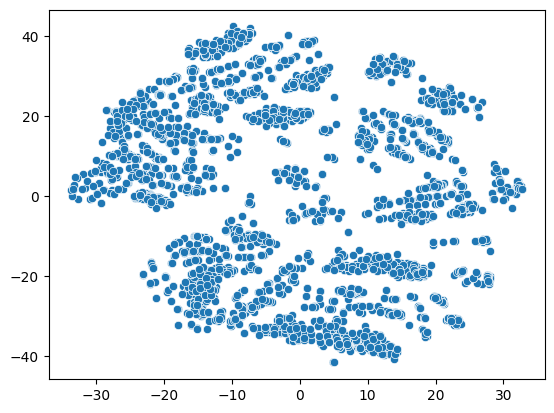

In [19]:
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1])

In [20]:
import pandas as pd
import plotly.express as px

# Преобразуем результат t-SNE в DataFrame
df_tsne = pd.DataFrame(X_embedded, columns=["TSNE-1", "TSNE-2"])

# Добавим метки классов и исходные признаки (или id)
df_tsne["original_index"] = train_features.index  # если надо знать, какая строка

# Можно добавить любые другие столбцы:
df_tsne["Year"] = train_features["Year"]
df_tsne["KM_Driven"] = train_features["KM_Driven"]
df_tsne["Fuel"] = train_features["Fuel"]

# Интерактивный график
fig = px.scatter(
    df_tsne,
    x="TSNE-1",
    y="TSNE-2",
    color="Year",  # можно менять на любой столбец
    hover_data=["Year", "KM_Driven", "Fuel"],  # здесь указываем, что показывать при наведении
)
fig.update_layout(title="t-SNE Visualization with Hover Info")
fig.show()

### **Задача** Сделайте выводы относительно использованных методов снижения размерности

PCA подходит для построения интерпретируемой проекции данных, tSNE для визуализации кластеров. Текущий датасет несколько не удачен для работы с этими алгоритмами.